Data Quality & Overview

How many rows and columns are in the dataset?



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('Data.csv',
                 encoding='ISO-8859-1',
                 parse_dates=["InvoiceDate"],
                 low_memory=False)
print(f"Loaded {df.shape[0]} rows & {df.shape[1]} columns.")

Loaded 112803 rows & 8 columns.


In [ ]:
print(df.shape)

(112803, 8)


What percentage of CustomerID and Description values are missing?

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
for col in ("CustomerID", "Description"):
  pct_missing = df[col].isna().mean()*100
  print(f"{pct_missing} of {col} values are missing.")

33.62942474934177 of CustomerID values are missing.
0.2881129047986313 of Description values are missing.


Are there any negative or zero values in Quantity or UnitPrice?

In [ ]:
for col in ("Quantity", "UnitPrice"):
  neg_values = (df[col]<=0).sum()
  print(f"Column '{col}' has {neg_values} negative values.")

Column 'Quantity' has 2310 negative values.
Column 'UnitPrice' has 566 negative values.


In [ ]:
df_clean = df.dropna(subset=["Description","CustomerID"])
print(f"After dropping missing fields {df_clean.shape[0]} rows remain.")

After dropping missing fields 74868 rows remain.


In [ ]:
df_sales =df_clean.query("Quantity > 0 and UnitPrice > 0").copy()
print(f"After dropping sales {df_sales.shape[0]} rows remain.")

After dropping sales 72889 rows remain.


In [ ]:
df_net = df_clean.query("UnitPrice > 0").copy()
print(f"After dropping net {df_net.shape[0]} rows remain.")

After dropping net 74861 rows remain.


In [ ]:
for d in (df_sales, df_net):
  d["TotalPrice"] = d["Quantity"]*d["UnitPrice"]
df_sales.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Sales Volume & Revenue

What is the total revenue (sum of Quantity * UnitPrice) over the entire period?

In [ ]:
Total_Revenue = df_net["TotalPrice"].sum()
Total_Items = df_sales["Quantity"].sum()
print(f"Net Revenue: {Total_Revenue:.2f}")
print(f"Total Items: {Total_Items:,}")

Net Revenue: 1584824.50
Total Items: 995,093


How does monthly revenue trend over time?

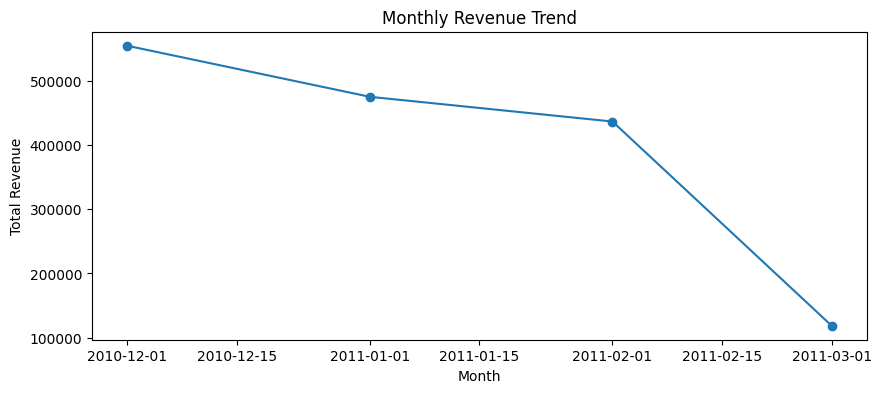

In [ ]:
df_net["Month"] = df_net["InvoiceDate"].dt.to_period("M")
monthly_rev = df_net.groupby("Month")["TotalPrice"].sum().to_timestamp()
plt.figure(figsize=(10,4))
plt.plot(monthly_rev.index, monthly_rev.values, marker = "o")
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.title("Monthly Revenue Trend")
plt.show()

Which weekday has the highest average sales volume?

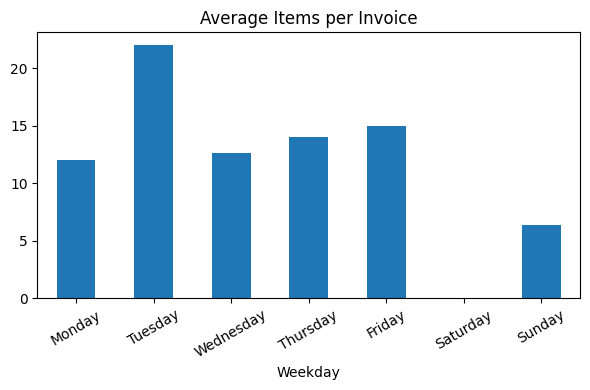

In [ ]:
df_sales["Weekday"] = df_sales["InvoiceDate"].dt.day_name()
Weekday_avg = (df_sales.groupby("Weekday")["Quantity"].mean().reindex(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])).round(2)
plt.figure(figsize=(6,4))
Weekday_avg.plot(kind= "bar")
plt.title("Average Items per Invoice")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Product Analysis

What are the top 10 products by quanntity sold vs.  total revenue?

In [ ]:
top_by_qty = df_sales.groupby("Description")["Quantity"].sum().nlargest(10)
top_by_rev = df_sales.groupby("Description")["TotalPrice"].sum().nlargest(10)
print(top_by_qty)
print(" ")
print(top_by_rev)

Description
MEDIUM CERAMIC TOP STORAGE JAR        74215
WORLD WAR 2 GLIDERS ASSTD DESIGNS     12340
WHITE HANGING HEART T-LIGHT HOLDER    11227
PACK OF 72 RETROSPOT CAKE CASES        9421
JUMBO BAG RED RETROSPOT                8629
GROW A FLYTRAP OR SUNFLOWER IN TIN     6915
SMALL POPCORN HOLDER                   6703
MINI PAINT SET VINTAGE                 6445
ASSORTED COLOUR BIRD ORNAMENT          5978
PACK OF 12 LONDON TISSUES              5868
Name: Quantity, dtype: int64
 
Description
MEDIUM CERAMIC TOP STORAGE JAR        77183.60
REGENCY CAKESTAND 3 TIER              41990.10
WHITE HANGING HEART T-LIGHT HOLDER    30404.95
CHILLI LIGHTS                         15715.61
JUMBO BAG RED RETROSPOT               15048.15
VINTAGE UNION JACK MEMOBOARD          14119.53
POSTAGE                               13336.00
WOOD BLACK BOARD ANT WHITE FINISH     10855.16
HEART OF WICKER LARGE                 10700.42
SET OF 3 CAKE TINS PANTRY DESIGN       9774.75
Name: TotalPrice, dtype: float64


What does the distribution of the line-item Quantity look like?(Any extreme bulk orders?)


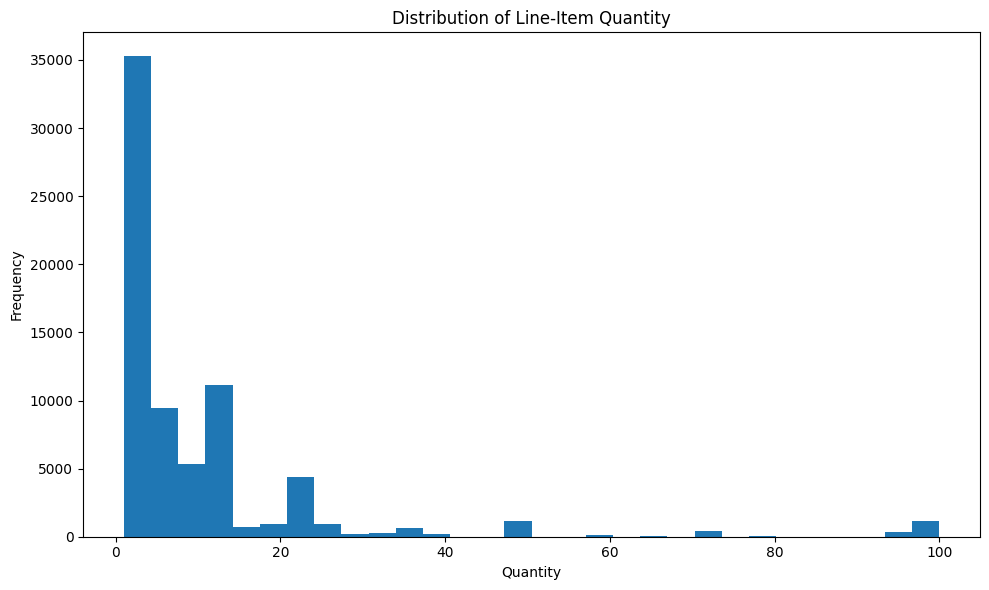

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df_sales["Quantity"].clip(upper=100),bins = 30)
plt.title("Distribution of Line-Item Quantity")
plt.xlabel("Quantity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

What is the typical range and distribution of the prize?

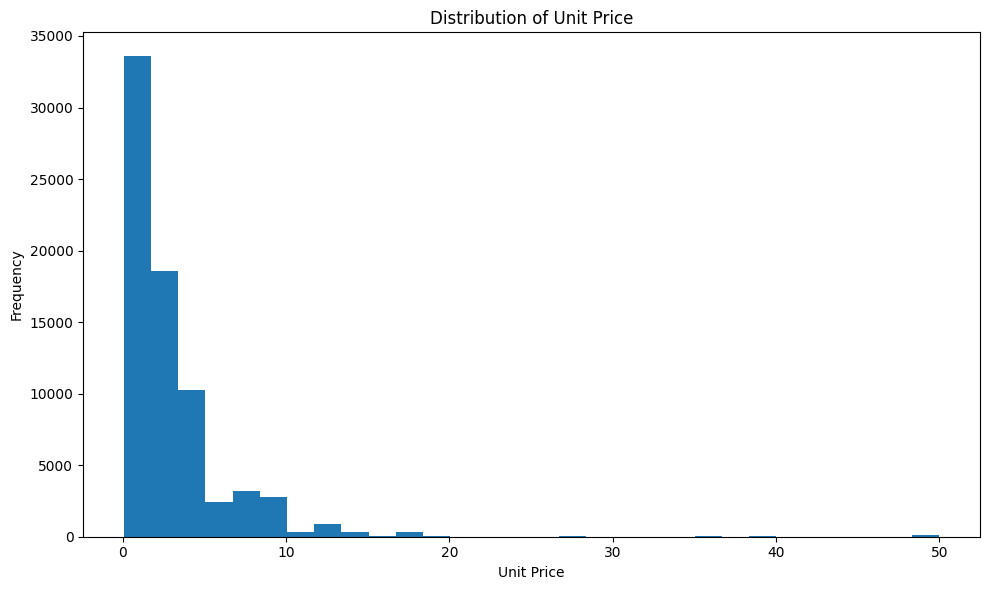

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df_sales["UnitPrice"].clip(upper=50),bins = 30)
plt.title("Distribution of Unit Price")
plt.xlabel("Unit Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Customer Behavior

How many unique customers are there?

What share are one-time vs repeat buyers?

In [ ]:
cust_order = df_sales.groupby("CustomerID")["InvoiceNo"].nunique()
repeat_rate = (cust_order > 1).mean()
one_time = (cust_order == 1).mean()
print(f"Customer size: {cust_order.size}")
print(f"Repeat Rate: {repeat_rate:.2%}")
print(f"One time rate {one_time:.2%}")

Customer size: 1790
Repeat Rate: 39.27%
One time rate 60.73%


What is the average order value ( AOV ) per customer?

In [ ]:
cust_rev = df_sales.groupby("CustomerID")["TotalPrice"].sum()
print(cust_rev.mean())

955.8156089385475


Which countries drive the most revenue?

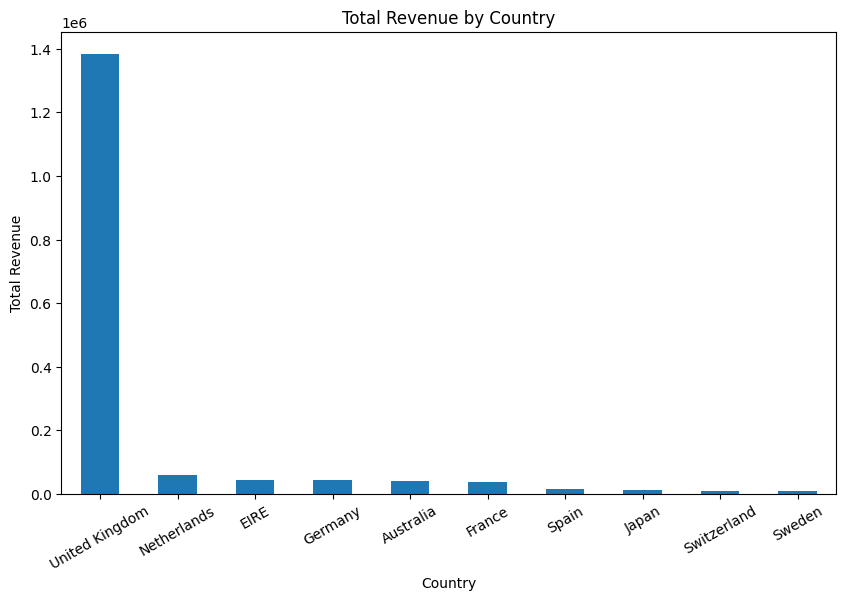

In [ ]:
country_rev = df_sales.groupby("Country")["TotalPrice"].sum().nlargest(10)
plt.figure(figsize=(10,6))
country_rev.plot(kind="bar")
plt.title("Total Revenue by Country")
plt.xticks(rotation=30)
plt.ylabel("Total Revenue")
plt.show()

Seasonality & Time Series

Are there clear seasonal patterns - which months or quarters spike?

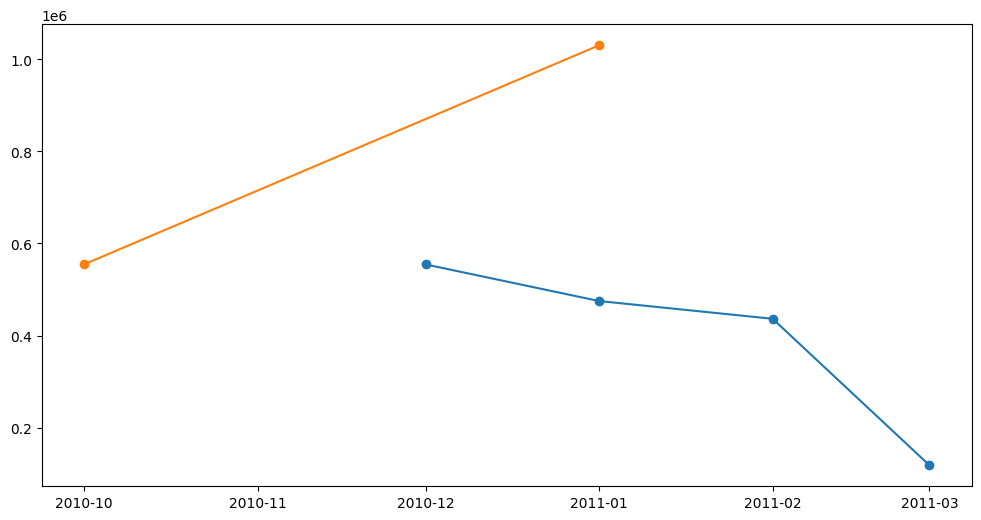

In [ ]:
monthly_rev = df_net.groupby(df_net["InvoiceDate"].dt.to_period("M"))["TotalPrice"].sum().to_timestamp()
quaterly_rev = df_net.groupby(df_net["InvoiceDate"].dt.to_period("Q"))["TotalPrice"].sum().to_timestamp()
plt.figure(figsize=(12,6))
plt.plot(monthly_rev.index,monthly_rev.values,marker="o",label="monthly")
plt.plot(quaterly_rev.index,quaterly_rev.values,marker="o",label="quaterly")


Plot a rolling 30-day revenue average to smooth out noise?

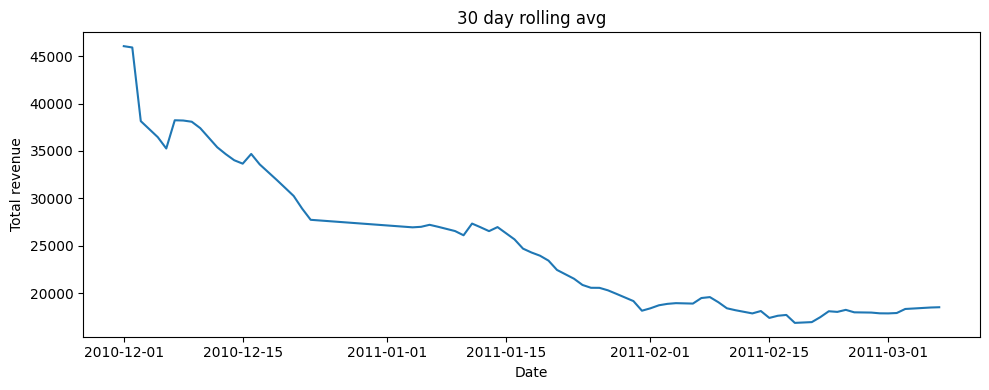

In [ ]:
daily_net = df_net.groupby(df_net["InvoiceDate"].dt.date)["TotalPrice"].sum()
rolling_30 = daily_net.rolling(window = 30, min_periods =1).mean()
plt.figure(figsize=(10,4))
plt.plot(rolling_30.index, rolling_30.values)
plt.title("30 day rolling avg")
plt.xlabel("Date")
plt.ylabel("Total revenue")
plt.tight_layout()
plt.show()